In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib import gridspec
from matplotlib import colorbar
from matplotlib import gridspec
from matplotlib import colors
import matplotlib as mpl
import pandas as pd
import os
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in", "ytick.direction": "in"})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.2, as_cmap=True)

In [2]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
AGE=np.arange(.15,6.05,.05)

tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]

In [100]:
g_grid = np.zeros([metal.size,AGE.size,len(tau)])
for i in range(metal.size):
    g_grid[i]=np.load('../data/m%s_gbf.npy' % metal[i]).T
#     print np.load('../data/m%s_gbf.npy' % metal[i]).T.shape

    
age_conv2 = np.load('../data/light_weight_scaling_2.npy')

In [73]:
g_grid.shape

(29, 118, 31)

In [19]:
AGE.shape

(118,)

In [101]:
l_dist2= age_conv2[17].T

In [66]:
ultau=np.append(0.0001,10**(np.array(tau[1:])-9))

In [7]:
def SFH(AGE,TAU):
    return AGE*np.exp(-AGE/TAU)

In [76]:
def LWA(dist,tau):
    top = np.zeros(len(dist))
    bottom = np.zeros(len(dist))

    for i in range(len(dist)):
        top[i] = np.trapz(SFH(AGE,tau)[0:i+1] * dist[0:i+1] * (AGE[i] - AGE[0:i+1]),AGE[0:i+1])
        bottom[i] = np.trapz(SFH(AGE,tau)[0:i+1]*dist[0:i+1],AGE[0:i+1])
    
    return top/bottom

def LWA2(dist,tau):
    dst = np.append(2*dist[0]-dist[1],dist)
    
    iage = np.arange(0,6.01,.01)

    hiressfh=SFH(iage,tau)
    idst = interp1d(np.append(0,AGE),dst)(iage)
    
    top = np.zeros(len(idst)-1)
    bottom = np.zeros(len(idst)-1)
    
    for i in range(len(idst)-1):
        top[i] = np.trapz(hiressfh[0:i+1] * idst[0:i+1] * (iage[i+1] - iage[0:i+1]),iage[0:i+1])
        bottom[i] = np.trapz(hiressfh[0:i+1] * idst[0:i+1],iage[0:i+1])
    
    lwa = interp1d(np.arange(0.01,6.01,.01),top/bottom)(age)
    
    return lwa

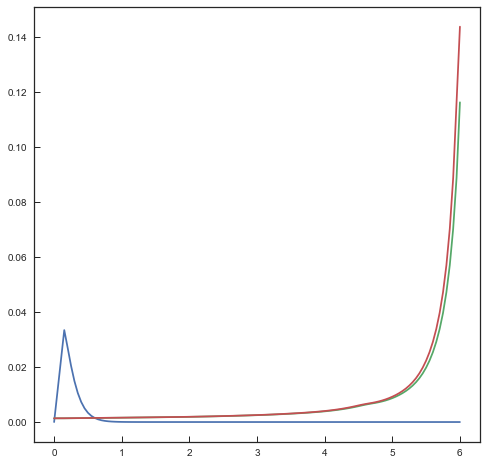

In [63]:
%matplotlib inline

dst1=np.append(g_grid[17].T[1],g_grid[17].T[1][-1])[::-1]
dst2=np.append(2*g_grid[17].T[1][0]-g_grid[17].T[1][1],g_grid[17].T[1])[::-1]

plt.figure(figsize=[8,8])
plt.plot(np.append(0,AGE),SFH(np.append(0,AGE),ultau[1]))
plt.plot(np.append(0,AGE),dst1)
plt.plot(np.append(0,AGE),dst2)

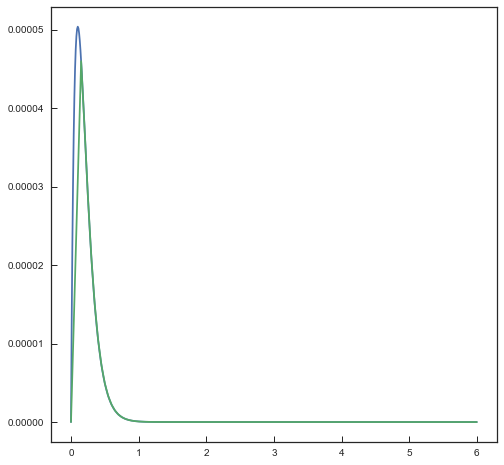

In [65]:
%matplotlib inline

iage = np.arange(0,6.01,.01)

hiressfh=SFH(iage,ultau[1])
dst=np.append(2*g_grid[17].T[1][0]-g_grid[17].T[1][1],g_grid[17].T[1])[::-1]
idst = interp1d(np.append(0,AGE),dst)(iage)

plt.figure(figsize=[8,8])
plt.plot(iage,hiressfh*idst)
plt.plot(np.append(0,AGE),SFH(np.append(0,AGE),ultau[1])*dst2)

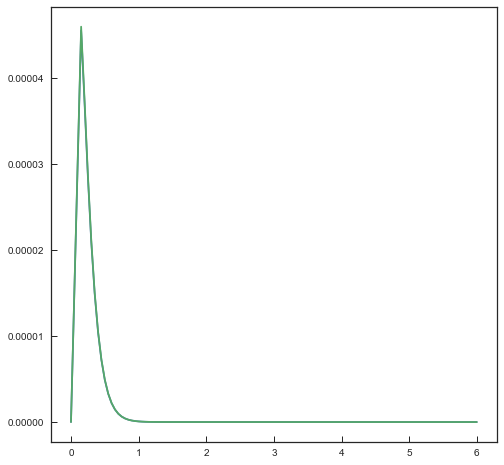

In [64]:
%matplotlib inline

plt.figure(figsize=[8,8])
plt.plot(np.append(0,AGE),SFH(np.append(0,AGE),ultau[1])*dst1)
plt.plot(np.append(0,AGE),SFH(np.append(0,AGE),ultau[1])*dst2)

In [89]:
test = LWA(g_grid[17].T[2][::-1],ultau[2])
test2 = LWA2(g_grid[17].T[2][::-1],ultau[2])

/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in divide


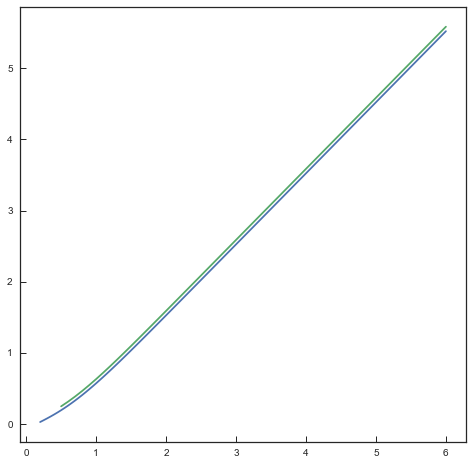

In [90]:
plt.figure(figsize=[8,8])
plt.plot(AGE,test)
plt.plot(age,test2)

<function matplotlib.pyplot.close>

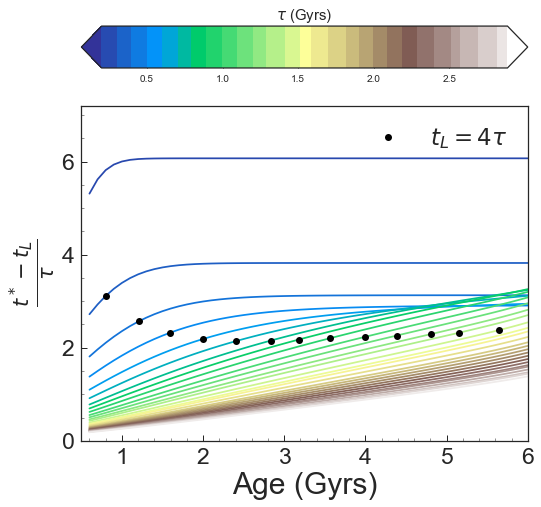

In [121]:
%matplotlib inline

col_list = sea.mpl_palette('terrain',ultau[1:].size)

gs =gridspec.GridSpec(2,1,height_ratios=[1,8])
plt.figure(figsize=[8,8])
ax = plt.subplot(gs[0])
cmap = mpl.cm.get_cmap('terrain')

bounds =ultau[1:]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                extend='both',
                                ticks=[.1,.5,1.0,1.5,2.0,2.5,3.0],
                                spacing='proportional',
                                orientation='horizontal')
plt.tick_params(axis='x', which='major', labelsize=10)
plt.title('$\\tau$ (Gyrs)',fontsize=15)

plt.subplot(gs[1])
for i in range(len(l_dist)-1):
    plt.plot(age,(age - l_dist[i+1])/ultau[i+1],color=col_list[i])
    
    if .5 <= ultau[i+1]*4 <= 6: 
        plt.plot(ultau[i+1]*4,interp1d(age,(age - l_dist[i+1])/ultau[i+1])(ultau[i+1]*4),'ko')
plt.plot(0,0,'ko',label = '$t_L = 4\\tau$')
plt.legend(loc=1,fontsize=23)
plt.axis([.5,6,0,7.2])
plt.xlabel('Age (Gyrs)',fontsize=30)
plt.ylabel('$\\frac{t^* - t_L}{\\tau}$',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.savefig('../plots/tau_limit.pdf',bbox_inches = 'tight')
plt.close

In [94]:
l_dist= age_conv[17].T

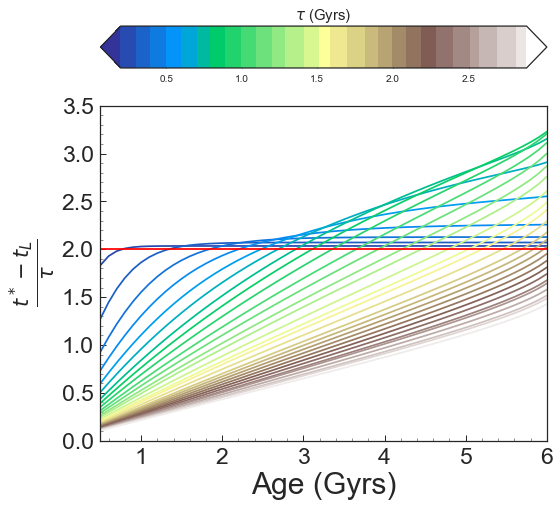

In [109]:
%matplotlib inline

col_list = sea.mpl_palette('terrain',ultau[1:].size)

gs =gridspec.GridSpec(2,1,height_ratios=[1,8])
plt.figure(figsize=[8,8])
ax = plt.subplot(gs[0])
cmap = mpl.cm.get_cmap('terrain')

bounds =ultau[1:]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                extend='both',
                                ticks=[.1,.5,1.0,1.5,2.0,2.5,3.0],
                                spacing='proportional',
                                orientation='horizontal')
plt.tick_params(axis='x', which='major', labelsize=10)
plt.title('$\\tau$ (Gyrs)',fontsize=15)

plt.subplot(gs[1])
for i in range(len(l_dist)-1):
    plt.plot(age,(age - l_dist[i+1])/ultau[i+1],color=col_list[i])
    
#     if .5 <= ultau[i+1]*4 <= 6: 
#         plt.plot(ultau[i+1]*4,interp1d(age,(age - l_dist[i+1])/ultau[i+1])(ultau[i+1]*4),'ko')
# plt.plot(0,0,'ko',label = '$t_L = 4\\tau$')
plt.axhline(2,color='r')
plt.legend(loc=1,fontsize=23)
plt.axis([.5,6,0,3.5])
plt.xlabel('Age (Gyrs)',fontsize=30)
plt.ylabel('$\\frac{t^* - t_L}{\\tau}$',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
# plt.savefig('../plots/tau_limit.pdf',bbox_inches = 'tight')
# plt.close

/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


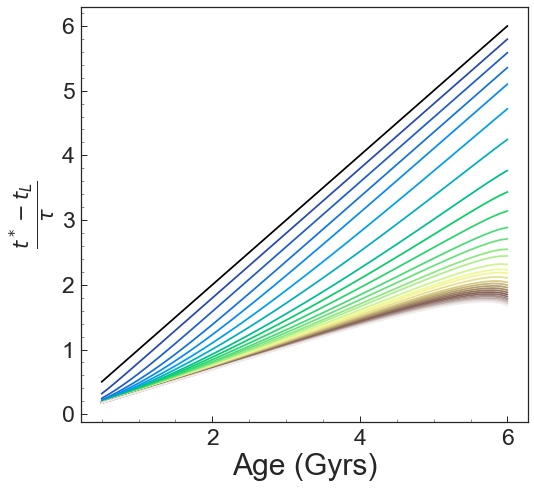

In [98]:
%matplotlib inline

plt.figure(figsize=[8,8])

plt.plot(age,age,color='k')

for i in range(len(l_dist)-1):
    plt.plot(age,l_dist[i+1],color=col_list[i])
plt.legend(loc=1,fontsize=23)
# plt.axis([.5,6,0,7.2])
plt.xlabel('Age (Gyrs)',fontsize=30)
plt.ylabel('$\\frac{t^* - t_L}{\\tau}$',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)

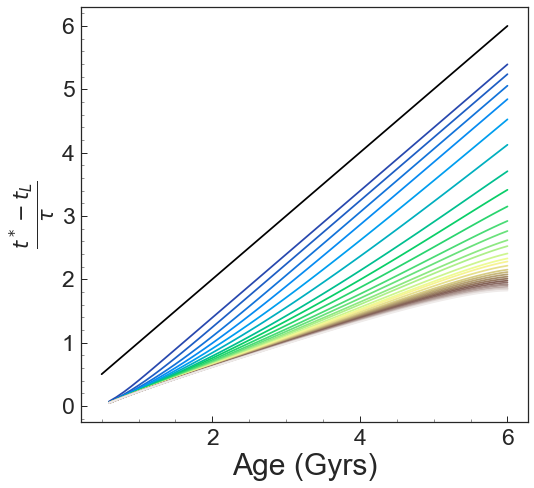

In [102]:
%matplotlib inline

plt.figure(figsize=[8,8])

plt.plot(age,age,color='k')

for i in range(len(l_dist2)-1):
    plt.plot(age,l_dist2[i+1],color=col_list[i])
plt.legend(loc=1,fontsize=23)
# plt.axis([.5,6,0,7.2])
plt.xlabel('Age (Gyrs)',fontsize=30)
plt.ylabel('$\\frac{t^* - t_L}{\\tau}$',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)

In [93]:
age_conv=np.zeros([metal.size,age.size,len(tau)])

for i in range(metal.size):
    for ii in range(len(tau)):
        age_conv[i].T[ii] = LWA2(g_grid[i].T[ii][::-1],ultau[ii])

/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in divide


In [103]:
np.save('../data/light_weight_scaling_3.npy',age_conv)